# Import libraries

In [1]:
# General
import os
import pathlib
import pickle

# Analysis
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sn

# Machine learning
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate,cross_val_score

# Autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Import project preprocessed data
from package_folder import preprocessor_light 

# 1. Load data, create X and Y, preprocess

In [3]:
#Load raw data
ROOT_PATH = pathlib.Path().resolve().parent # Get the parent directory of the current working directory
raw_data_path = os.path.join(ROOT_PATH, 'raw_data', 'Loan_Default.csv')
print(raw_data_path)

/home/yann/code/YannAll/automated_loan_review_project/raw_data/Loan_Default.csv


In [4]:
data = pd.read_csv(raw_data_path)

In [5]:
data.columns

Index(['ID', 'year', 'loan_limit', 'Gender', 'approv_in_adv', 'loan_type',
       'loan_purpose', 'Credit_Worthiness', 'open_credit',
       'business_or_commercial', 'loan_amount', 'rate_of_interest',
       'Interest_rate_spread', 'Upfront_charges', 'term', 'Neg_ammortization',
       'interest_only', 'lump_sum_payment', 'property_value',
       'construction_type', 'occupancy_type', 'Secured_by', 'total_units',
       'income', 'credit_type', 'Credit_Score', 'co-applicant_credit_type',
       'age', 'submission_of_application', 'LTV', 'Region', 'Security_Type',
       'Status', 'dtir1'],
      dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [7]:
data.iloc[100]

ID                               24990
year                              2019
loan_limit                          cf
Gender                            Male
approv_in_adv                    nopre
loan_type                        type1
loan_purpose                        p1
Credit_Worthiness                   l1
open_credit                       nopc
business_or_commercial           nob/c
loan_amount                     186500
rate_of_interest                 4.875
Interest_rate_spread            0.3555
Upfront_charges                 4950.0
term                             360.0
Neg_ammortization              not_neg
interest_only                  not_int
lump_sum_payment              not_lpsm
property_value                348000.0
construction_type                   sb
occupancy_type                      pr
Secured_by                        home
total_units                         1U
income                          2880.0
credit_type                        EXP
Credit_Score             

In [8]:
full_pipeline = preprocessor_light.create_preprocessing_pipeline()

In [9]:
full_pipeline

Pipeline(steps=[('cleaner', DataCleaner()), ('dropper', ColumnDropper()),
                ('cat_imputer', CategoricalImputer()),
                ('encoder', CategoricalEncoder()),
                ('simple_imputer', SimpleImputerTransformer()),
                ('outlier_remover', OutlierRemover()),
                ('scaler', MinMaxScalerTransformer())])

In [10]:
data_processed=full_pipeline.fit_transform(data)

✅ Data cleaned
✅ Columns ['year', 'ID', 'Interest_rate_spread', 'Upfront_charges', 'LTV', 'dtir1'] dropped
✅ Missing values in categorical variables imputed
✅ Categorical variables encoded successfully, including 'term'
✅ Missing values imputed with Simple Imputer (mean), remaining NaNs filled with 0
✅ Outliers removed based on IQR threshold
✅ Continuous variables scaled between 0 and 1


In [11]:
X = data_processed.drop(columns='loan_amount')
y = data_processed["loan_amount"]

In [12]:
X_column_names=list(X.columns)

In [13]:
print(f"X_shape: {X.shape} y shape: {y.shape}")

X_shape: (143944, 91) y shape: (143944,)


# 2. Instantiate, cross validate, train and evaluate the base model

In [14]:
#Instantiate basic regression model
linear_regression=LinearRegression(n_jobs=1000)

In [15]:
#Create train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [16]:
#Cross validate data
from sklearn.model_selection import cross_validate
base_model_score=cross_validate(linear_regression,X_train,y_train,cv=5,verbose=0)['test_score'].mean()
print(f"base model: {base_model_score}")

base model: -2.5521289562338772e+16


In [17]:
#Observation: the R2 of this regression is unusually negative. It signals a problem with the input data.
#Assumption: the problem is the high colinearity between our features

<Axes: >

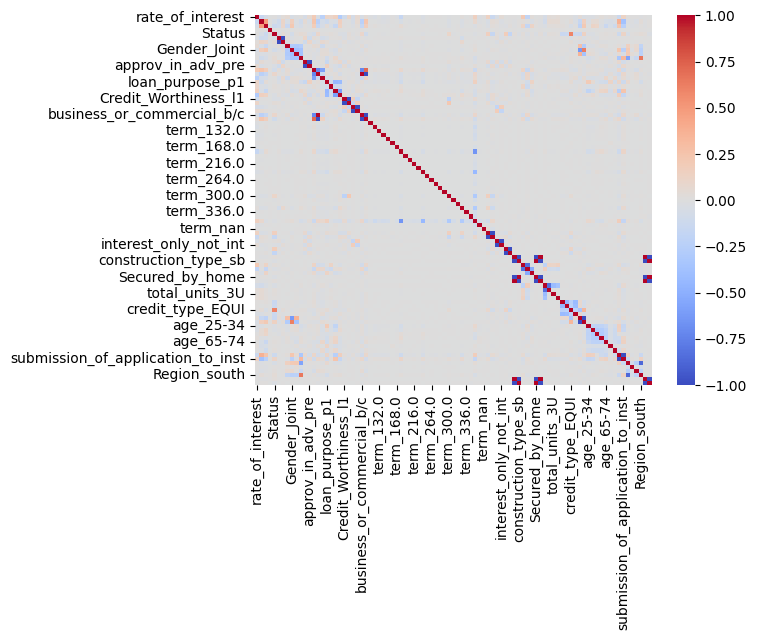

In [18]:
#Visualize colinearity
sn.heatmap(X_train.corr(),cmap='coolwarm')

# 3. Instantiate, cross validate, train and evaluate the base model AFTER dimensionality reduction

In [22]:
#Import preprocessing pipeline from package folder
from package_folder import preprocessor_for_regression
full_pipeline = preprocessor_for_regression.process_data()

🔍 Checking for file at path: /home/yann/code/YannAll/automated_loan_review_project/raw_data/Loan_Default.csv
✅ Data loaded successfully
0
✅ Data cleaned
✅ Missing values in categorical variables imputed
✅ Categorical variables encoded successfully, including 'term'
✅ Missing values imputed with Simple Imputer (mean), remaining NaNs filled with 0
✅ Continuous variables scaled and centered around 0
✅ Dimensionality reduced to 24 features with a PCA


In [23]:
data_processed_PCA= full_pipeline.fit_transform(data)

✅ Data cleaned
✅ Missing values in categorical variables imputed
✅ Categorical variables encoded successfully, including 'term'
✅ Missing values imputed with Simple Imputer (mean), remaining NaNs filled with 0
✅ Continuous variables scaled and centered around 0
✅ Dimensionality reduced to 24 features with a PCA


In [24]:
columns=[f"PC{i}" for i in range(1,25)]+['rate_of_interest']
data_processed_PCA = pd.DataFrame(data_processed_PCA,columns=columns)

In [49]:
data_processed_PCA=data_processed_PCA.dropna()

In [51]:
linear_regression=LinearRegression(n_jobs=100)

In [52]:
#Create X and y 
X = data_processed_PCA.drop(columns='rate_of_interest')
y = data_processed_PCA["rate_of_interest"]

In [53]:
#Train test split
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [54]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((89784, 24), (89784,), (22447, 24), (22447,))

<Axes: >

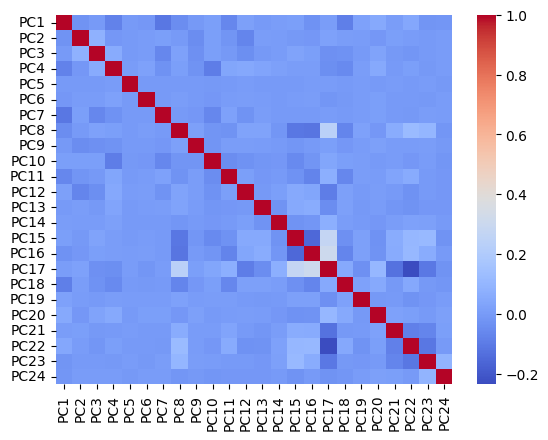

In [56]:
#Visualize colinearity
sn.heatmap(X_train.corr(),cmap='coolwarm')

In [57]:
#Cross validate X dataset reduced thanks to PCA 
cv_results=cross_validate(linear_regression,X_train,y_train,cv=5,verbose=0)['test_score'].mean()
print(f"CV results: {cv_results}")

CV results: 0.6138105747777969


In [58]:
#Fit the model
linear_regression.fit(X_train,y_train)

LinearRegression(n_jobs=100)

In [59]:
#Predict on X_test
y_pred_scaled=linear_regression.predict(X_test)

In [60]:
y_pred_scaled

array([3.56794798, 3.96997475, 4.43602753, ..., 4.07889424, 4.05868794,
       3.49861546])

In [61]:
y_test

18660     4.125
139808    4.560
2714      3.875
83275     3.875
45976     4.990
          ...  
48717     3.990
54369     4.500
58792     3.875
140514    4.500
48932     4.000
Name: rate_of_interest, Length: 22447, dtype: float64

In [62]:
#Conclusion: this looks quite promising. Let's now see if we can improve performance a bit by tuning the model!

In [63]:
#Dump linear regression model into a pickle file
linear_regression_model_path = os.path.join(ROOT_PATH, 'models', 'linear_regression')
with open(linear_regression_model_path, 'wb') as file: 
     pickle.dump(linear_regression, file)
print(f"linear_regression successfully saved to {linear_regression_model_path}")

linear_regression successfully saved to /home/yann/code/YannAll/automated_loan_review_project/models/linear_regression


## 4. Model tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

# Instantiate model
model = ElasticNet()

# Hyperparameter Grid
grid = {'l1_ratio': stats.uniform(0, 1), 'alpha': [0.001, 0.01, 0.1, 1]}

# Instantiate Grid Search
search = RandomizedSearchCV(
    model,
    grid,
    scoring='r2',
    n_iter=100,  # number of draws
    cv=5, n_jobs=-1
)

# Fit data to Grid Search
search.fit(X_train, y_train)

#Print results
# Best score
print(search.best_score_)

# Best Params
print(search.best_params_)

# Best estimator
print(search.best_estimator_)